In [2]:
%reload_ext autoreload
%autoreload 2

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers
from dominoes import datasets
from dominoes import training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output
# 4. Analyze why the abrupt increases in loss happen during pointer demonstration
#    - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the loss

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------


In [266]:
# Immediate to-do
# 1. Finish up transition to REINFORCE algorithm for pointer sequencing
#    - also do this for the pointer demonstration
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
#    - Predict this with a value function too. 
# 4. Divide pointer network into "encoder" and "decoder" blocks to reuse the encoder (and append value)
# 5. Try new versions of pointer attention:
#    - simple attention (not a transformer layer) then single (N -> 1) FF layer
#    - dot product between decoder_context and encoded_representations then softmax over that
# --
# also
# --
# 1. Test simpler TD agents on a probability of winning based value, rather than score!


# Good Coding Practice:
# 1. Convert measure reward to class
# 2. Make a class for all these methods going to the experiments (batch, pad, etc.)

# Representations:
# 1. Make clean and nicely stored system for representing outputs in hand sequencing

Training network...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.03it/s]


Testing network...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.12it/s]


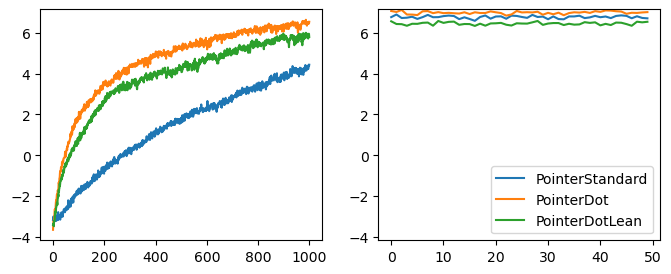

In [51]:
#### set up toy experiment with a simple problem and pointer network to test the REINFORCE algorithm
# start with 'pointerDemonstration' code and reward dominoes in order of highest value, not rewarding already played dominoes, and discounting future dominoes...

# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
dominoeValue = np.sum(listDominoes, axis=1)


# do subselection for training
doubleDominoes = listDominoes[:,0] == listDominoes[:,1]
nonDoubleReverse = listDominoes[~doubleDominoes][:,[1,0]] # represent each dominoe in both orders

# list of full set of dominoe representations and value of each
listDominoes = np.concatenate((listDominoes, nonDoubleReverse), axis=0)
dominoeValue = np.sum(listDominoes, axis=1)

# subset dominoes
keepFraction = 0.75
keepNumber = int(len(listDominoes)*keepFraction)
keepIndex = np.sort(np.random.permutation(len(listDominoes))[:keepNumber]) # keep random fraction (but sort in same way)
keepDominoes = listDominoes[keepIndex]
keepValue = dominoeValue[keepIndex]


ignoreIndex = -1
handSize = 8
batchSize = 512

input_dim = 2*(highestDominoe+1)
embedding_dim = 48
heads = 1
encoding_layers = 1
greedy = True
temperature = 5.0
thompson = True
maxOutput = handSize

trainEpochs = 1000
testEpochs = 50

gamma = 1.0
exponent = torch.arange(maxOutput).view(-1,1) - torch.arange(maxOutput).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batchSize, -1, -1).to(device)


# do reinforcement learning
batch_inputs = {'null_token':False, 
                'available_token':False, 
                'ignore_index':ignoreIndex, 
                'return_full':True,
                'return_target':False,
               }

pointer_methods = ['PointerStandard', 'PointerDot', 'PointerDotLean'] #, 'PointerAttention', 'PointerTransformer']
pnets = [transformers.PointerNetwork(input_dim, embedding_dim, temperature=temperature, pointer_method=pointer_method, thompson=thompson,
                                     encoding_layers=encoding_layers, heads=heads, kqnorm=True, decode_with_gru=False, greedy=greedy)
         for pointer_method in pointer_methods]
pnets = [pnet.to(device) for pnet in pnets]
for pnet in pnets: pnet.train()

# Create an optimizer, Adam with weight decay is pretty good
optimizers = [torch.optim.Adam(pnet.parameters(), lr=1e-3, weight_decay=1e-5) for pnet in pnets]

numNets = len(pnets)

# Train network
print("Training network...")
trainLoss = torch.zeros((trainEpochs, numNets))
trainReward = torch.zeros((trainEpochs, maxOutput, numNets))
for epoch in tqdm(range(trainEpochs)):
    batch = datasets.generateBatch(highestDominoe, keepDominoes, batchSize, handSize, **batch_inputs)

    # unpack batch tuple
    input, _, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)
    
    # zero gradients, get output of network
    for opt in optimizers: opt.zero_grad()
    log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))

    # log-probability for each chosen dominoe
    logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
    
    # measure reward
    rewards = [training.measureReward_sortDescend(keepDominoes[selection], choice) for choice in choices]
    G = [torch.bmm(reward.unsqueeze(1), gamma_transform).squeeze(1) for reward in rewards]

    # measure J
    J = [-torch.sum(logpol * g) for logpol, g in zip(logprob_policy, G)]
    for j in J: j.backward()
    
    for opt in optimizers: opt.step()
    
    # save training data
    for i in range(numNets):
        trainLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))
        trainReward[epoch, :, i] = torch.mean(rewards[i], dim=0)

with torch.no_grad():
    for pnet in pnets: 
        pnet.setTemperature(1.0)
        pnet.setThompson(False)
        
    print('Testing network...')
    testLoss = torch.zeros((testEpochs, numNets))
    for epoch in tqdm(range(testEpochs)):
        batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)

        # unpack batch tuple
        input, _, _, _, _, selection, available = batch
    
        # move to correct device
        input = input.to(device)
        
        # get output of network
        log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))
    
        # log-probability for each chosen dominoe
        logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
        
        # measure reward
        rewards = [training.measureReward_sortDescend(listDominoes[selection], choice) for choice in choices]
        
        # save training data
        for i in range(numNets):
            testLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))

plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,3))
for inet in range(numNets):
    name = f"{pointer_methods[inet]}"
    ax[0].plot(range(trainEpochs), trainLoss[:,inet].detach().cpu().numpy(), label=name)
    ax[1].plot(range(testEpochs), testLoss[:,inet].detach().cpu().numpy(), label=name)

ylims = ax[0].get_ylim()
ax[1].set_ylim(ylims)
ax[1].legend(loc='lower right')
plt.show()


In [1]:
# order of operations:
# 4. write documentation file explaining the experiment
# 5. develop these analyses, focus on pointer layer because that's where the new architectures are|

In [9]:
from pathlib import Path
train_method = 'with_thompson'
pointer_methods = ['PointerStandard', 'PointerDot']

resPath = Path('experiments') / 'savedResults'
savePath = Path('.') / 'experiments' / 'savedNetworks'
results = np.load(resPath / 'pointerArchitectureComparison.npy', allow_pickle=True).item()
pnets = []
for pointer_method in pointer_methods:
    name = f"pointerArchitectureComparison_{pointer_method}_{train_method}.pt"
    pnets.append(torch.load(savePath / name))
pnets = [pnet.to(device) for pnet in pnets]

In [11]:
# prepare inputs for network inspection
def pointerModule(pnet, encoded, decoder_input, decoder_context, max_output, mask):
    pointer_log_scores = []
    pointer_choices = []
    pointer_outs = []
    for i in range(max_output):
        # update context representation
        decoder_context = pnet.pointer.decode(encoded, decoder_input, decoder_context, mask)
        
        # use pointer attention to evaluate scores of each possible input given the context
        decoder_state = pnet.pointer.get_decoder_state(decoder_input, decoder_context)
        outs = pointerLayer(pnet, encoded, decoder_state, mask=mask)
        score = outs[0]
        intermediate = outs[1:]
        
        # standard loss function (nll_loss) requires log-probabilities
        log_score = score if pnet.greedy else torch.log(score)

        # choose token for this sample
        if pnet.pointer.thompson:
            # choose probabilistically
            choice = torch.multinomial(torch.exp(log_score), 1)
        else:
            # choose based on maximum score
            choice = torch.argmax(log_score, dim=1, keepdim=True)

        if pnet.greedy:
            # next decoder_input is whatever token had the highest probability
            index_tensor = choice.unsqueeze(-1).expand(batch_size, 1, pnet.embedding_dim)
            decoder_input = torch.gather(encoded, dim=1, index=index_tensor).squeeze(1)
        else:
            # next decoder_input is the dot product of token encodings and their probabilities
            decoder_input = torch.bmm(score.unsqueeze(1), encoded).squeeze(1)
            
        # Save output of each decoding round
        pointer_log_scores.append(log_score)
        pointer_choices.append(choice)
        pointer_outs.append(intermediate)
        
    log_scores = torch.stack(pointer_log_scores, 1)
    choices = torch.stack(pointer_choices, 1).squeeze(2)

    return log_scores, choices, pointer_outs
    
def pointerLayer(pnet, encoded, decoder_state, mask=None):
    if pnet.pointer_method == 'PointerStandard':
        tEncoded = pnet.pointer.pointer.W1(encoded)
        tDecoded = pnet.pointer.pointer.W2(decoder_state)
        u = pnet.pointer.pointer.vt(torch.tanh(tEncoded + tDecoded.unsqueeze(1))).squeeze(2)
        
    elif pnet.pointer_method == 'PointerDot':
        tEncoded = pnet.pointer.pointer.W1(encoded)
        tDecoded = pnet.pointer.pointer.W2(decoder_state)
        u = torch.bmm(tEncoded, tDecoded.unsqueeze(2)).squeeze(2)
        
    else:
        raise ValueError("did not recognize pointer method")

    # mask and compute softmax
    if mask is not None:
        u.masked_fill_(mask==0, -200) # only use valid tokens

    if pnet.pointer.pointer.log_softmax:
        # convert to log scores
        score = torch.nn.functional.log_softmax(u/pnet.pointer.temperature, dim=-1)
    else:
        # convert to probabilities
        score = torch.nn.functional.softmax(u/pnet.pointer.temperature, dim=-1)

    return score, tEncoded, tDecoded, u

# get a "normal" batch
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
numDominoes = len(listDominoes)
dominoeValue = np.sum(listDominoes, axis=1)
batchSize = 512
handSize = 8
batch_inputs = {'null_token':False, 
                'available_token':False, 
                'ignore_index':-1, 
                'return_full':True,
                'return_target':False,
               }

selection = np.array([])
while len(np.unique(selection))!=numDominoes:
    batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)
    
    # unpack batch tuple
    input, _, _, _, _, selection, available = batch
    input = input.to(device)

# pre-forward
batch_size, tokens, _ = input.size()
mask = torch.ones((batch_size, tokens), dtype=input.dtype).to(device)

# encoding
embedded = [pnet.embedding(input) for pnet in pnets]
encoded = [pnet.encoding(embed) for pnet, embed in zip(pnets, embedded)]

numerator= [torch.sum(enc*mask.unsqueeze(2), dim=1) for enc in encoded]
denominator = [torch.sum(mask, dim=1, keepdim=True) for _ in pnets]
decoder_context = [num/den for num, den in zip(numerator, denominator)]
decoder_input = [torch.zeros((batch_size, pnet.embedding_dim)).to(device) for pnet in pnets]

# this will work for all, but as of now I just am studying the PointerDot
idx_inspect = 0
scores, choices, outs = pointerModule(pnets[idx_inspect], 
                                      encoded[idx_inspect], 
                                      decoder_input[idx_inspect], 
                                      decoder_context[idx_inspect], 
                                      8, 
                                      mask)

ptr_encoded, ptr_decoded, ptr_u = map(list, zip(*outs)) # unpack for PointerDor
ptr_encoded = ptr_encoded[0].to('cpu') # they're all the same, only need the first. this is bad code at the moment!
ptr_decoded = torch.stack(ptr_decoded, dim=2).to('cpu') # only a single array, so stack across output sequence
ptr_u = torch.stack(ptr_u, dim=2).to('cpu') # only a single array, so stack across output sequence
choices = choices.to('cpu')

In [12]:
# make dominoe x embedding array to figure out sort index for units
emb_dim = ptr_encoded.size(2)
scatter_index = torch.tensor(selection, dtype=torch.long).view(-1,1)
dom_rep_encoded = torch.zeros((numDominoes, emb_dim), dtype=torch.float)
dom_rep_counts = torch.zeros((numDominoes, 1), dtype=torch.long)
dom_rep_encoded.scatter_add_(0, scatter_index.expand(-1, emb_dim), ptr_encoded.view(-1, emb_dim))
dom_rep_counts.scatter_add_(0, scatter_index, torch.ones_like(scatter_index, dtype=torch.long))
dom_rep_encoded /= dom_rep_counts # average encoding of each dominoe

In [13]:
# sort encoding and decodings
proj_value = torch.tensor(dominoeValue, dtype=torch.float) @ dom_rep_encoded
idx_dom_sort = np.argsort(dominoeValue)
idx_enc_sort = torch.argsort(-proj_value)

(48, 1)


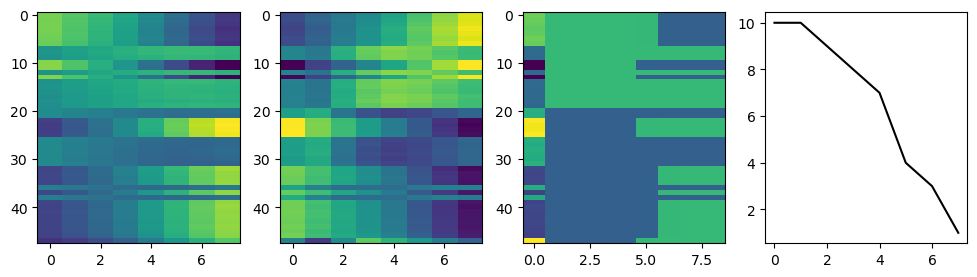

In [40]:
# pick batch index and show data
bidx = 0
batch_dominoes = listDominoes[selection[bidx]]
batch_value = np.sum(batch_dominoes, axis=1)

combined = ptr_encoded[bidx] + ptr_decoded[bidx][:,4]
ctrans = np.tanh(combined.T[idx_enc_sort][:,choices[bidx]].detach().numpy())
vtrans = pnets[0].pointer.pointer.vt.weight.detach().cpu().numpy()[0, idx_enc_sort].reshape(-1,1)
print(vtrans.shape)

plt.close('all')
fig, ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(ptr_encoded[bidx].T[idx_enc_sort][:,choices[bidx]].detach().numpy(), aspect='auto')
ax[1].imshow(ptr_decoded[bidx][idx_enc_sort].detach().numpy(), aspect='auto')
ax[2].imshow(np.hstack((vtrans, ctrans)), aspect='auto')
ax[3].plot(range(len(batch_value)), batch_value[choices[bidx]], color='k', label='dominoe value')
plt.show()

In [21]:
ptr_encoded[bidx].T.shape

torch.Size([48, 8])

In [22]:
ptr_decoded[bidx].shape

torch.Size([48, 8])

In [18]:
pnets[0].pointer.pointer.vt.weight

Parameter containing:
tensor([[ 1.5746, -0.8227,  1.5427, -1.5990, -0.7583,  0.6737, -1.5257, -1.6478,
         -2.6991, -1.5325,  1.4715,  0.8262, -1.5576, -0.7672, -0.7678,  1.5365,
         -1.5807,  2.7166,  2.8465,  1.5182,  2.7265, -0.8246, -1.5353, -0.7860,
         -1.5594,  0.7754, -0.7938,  0.7935,  0.8029, -0.7909, -0.8355,  1.6125,
          0.7227, -1.4762, -1.6237, -1.4842,  0.7157, -2.7168, -2.6982,  2.8165,
          1.6258, -0.7677,  0.7899,  0.7154,  0.7411,  2.8345, -1.5510, -1.5580]],
       device='cuda:0', requires_grad=True)

In [14]:
# the above is the right idea. need to write good code to:
# -- process and store intermediate activations of different pointer networks
# -- take a full batch of data (ensuring that each dominoe is represented) and sort activations 
#             - using rastermap, PCA, basic sort projection method
# -- show the encoding of different batches with the decoder dot representation
# -- show the decoder update rules (study the decoder transformer) NOTE THAT THIS IS COMPLICATED!!!
# -- show how encoding of the same dominoe changes depending on what other dominoes are present

In [87]:
# also, gotta quickly!!! move all the above code to an "analysis" module
# preferably in a new directory on the same level as dominoes and experiments...

In [ ]:
# also need some basic analyses of pointerArchitectureComparison, specifically the confidence measure!

In [ ]:
# and need to update above code to include breakdown of all the pointer_method layers